In [7]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from urllib.request import urlopen
import math
import datetime

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
drive_prefix = 'drive/My Drive/Andmeteadus2019projekt/'

#reading in all csv files
data1 = pd.read_csv(drive_prefix + "liiklusjarelevalve_1.csv", sep='\t', index_col=0, na_values='')
data2 = pd.read_csv(drive_prefix + "liiklusjarelevalve_2.csv", sep='\t', index_col=0, na_values='')
data3 = pd.read_csv(drive_prefix + "liiklusjarelevalve_3.csv", sep='\t', index_col=0, na_values='')

#concatenating data together and dropping duplicates (data from this year and last five years overlap)
data4 = pd.concat([data1, data2, data3]).drop_duplicates()

#dropping irrelevant columns
columns_to_drop = ['RikkujaElukoht', 'Loige', 'Punkt', 'RikutudOigusnorm']
data4 = data4.drop(columns=columns_to_drop, axis=1)


#Filling all nan values with a mode value (appears most often)
# data4 = data4.fillna(data4.mode().iloc[0])
old_KM = data4["KM"].copy()
data4 = data4.fillna(data4.mode().iloc[0])
data4["KM"] = old_KM
data4


,ToimKpv,ToimKell,ToimNadalapaev,Seadus,Paragrahv,ParagrahvTais,MaakondNimetus,ValdLinnNimetus,KohtNimetus,MntVoiTanav,MntTanavNimetus,KM,Lest_X,Lest_Y,SoidukLiik,SoidukRegRiik,SoidukMark,SoidukVlAasta,RikkujaSugu,RikkujaVanus,SyyteoLiik
JuhtumId,,,,,,,,,,,,,,,,,,,,,
2fd44f1c-6370-18d7-888c-967f31fec8f0,2019-11-06,23:50,Kolmapäev,Liiklusseadus,§ 227.,§ 227. Mootorsõidukijuhi poolt lubatud sõiduki...,Harju maakond,Tallinn,Haabersti linnaosa,TNV,Paldiski mnt,NaN,6588000-6588499,538500-538999,SOIDUAUTO,EST,HONDA,2007,M,35-44,VT
2fd44ee0-6370-18d7-888c-967f31fec8f0,2019-11-06,18:19,Kolmapäev,Liiklusseadus,§ 242.,§ 242. Mootorsõiduki- või trammijuhi poolt lii...,Pärnu maakond,Pärnu linn,Pärnu linn,TNV,Tallinna mnt,NaN,6472500-6472999,529000-529499,SOIDUAUTO,EST,AUDI,2007,M,26-34,VT
2fd44ecc-6370-18d7-888c-967f31fec8f0,2019-11-06,18:16,Kolmapäev,Liiklusseadus,§ 227.,§ 227. Mootorsõidukijuhi poolt lubatud sõiduki...,Ida-Viru maakond,Toila vald,Kaasikaia küla,TNV,TALLINN - TARTU - VÕRU - LUHAMAA (2),NaN,6591000-6591499,686500-686999,VEOAUTO,EST,FORD,2016,M,55-64,VT
2fd44ec2-6370-18d7-888c-967f31fec8f0,2019-11-06,18:08,Kolmapäev,Liiklusseadus,§ 242.,§ 242. Mootorsõiduki- või trammijuhi poolt lii...,Pärnu maakond,Pärnu linn,Pärnu linn,TNV,Tallinna mnt,NaN,6472500-6472999,528500-528999,SOIDUAUTO,EST,BMW,2008,M,26-34,VT
2fd44eae-6370-18d7-888c-967f31fec8f0,2019-11-06,17:55,Kolmapäev,Liiklusseadus,§ 227.,§ 227. Mootorsõidukijuhi poolt lubatud sõiduki...,Harju maakond,Tallinn,Haabersti linnaosa,TNV,Rannamõisa tee,NaN,6587500-6587999,536000-536499,VEOAUTO,EST,ŠKODA,2018,M,35-44,VT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95dfdfb2-1636-18d5-8326-a9a756483dba,2012-01-01,01:00,Pühapäev,Liiklusseadus,§ 236.,§ 236. Liiklusõnnetusest mitteteatamine,Harju maakond,Tallinna linn,Kesklinna linnaosa,TNV,Estonia pst,NaN,6588500-6588999,542500-542999,SOIDUAUTO,EST,MERCEDES-BENZ,1998,M,45-54,VT
95dfe0b6-1636-18d5-8326-a9a756483dba,2012-01-01,00:52,Pühapäev,Liiklusseadus,§ 227.,§ 227. Mootorsõidukijuhi poolt lubatud sõiduki...,Harju maakond,Tallinna linn,Lasnamäe linnaosa,TNV,Peterburi tee,NaN,6588000-6588499,547500-547999,SOIDUAUTO,EST,AUDI,1997,M,35-44,VT
95dfdf9e-1636-18d5-8326-a9a756483dba,2012-01-01,00:20,Pühapäev,Liiklusseadus,§ 224.,"§ 224. Mootorsõiduki, maastikusõiduki või tram...",Jõgeva maakond,Torma vald,Torma vald,MNT,TORMA - KIVIJÄRVE (14117),4.0,6521500-6521999,654500-654999,SOIDUAUTO,EST,VOLKSWAGEN,1995,M,55-64,VT


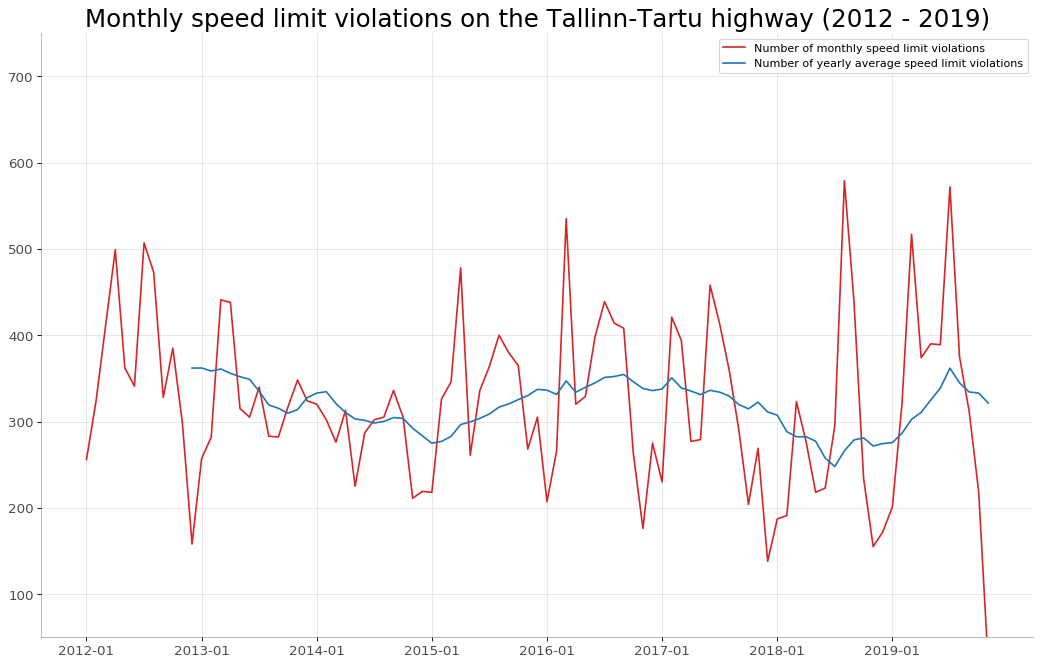

In [9]:
###################################################
##########      LIIKLUSKAAMERAD      ##############
###################################################

#Copy the main dataframe
data_kaamerad = data4[data4["MntVoiTanav"] == "MNT"].copy()

#Change the date column to a date type
data_kaamerad["ToimKpv"] = pd.to_datetime(data_kaamerad["ToimKpv"])

#Choose all of the rows that are on the Talllin-Tartu highway, and the misdemeanor is speeding.
data_kaamerad = data_kaamerad[(data_kaamerad['MntTanavNimetus'].str.contains("TALLINN")) & (data_kaamerad['MntTanavNimetus'].str.contains("TARTU")) & (data_kaamerad['Paragrahv'] == "§ 227.")]

#Choose only the necessary rows
data_kaamerad_TLN_TRT_graph = data_kaamerad[["ToimKpv", "Paragrahv"]]
#Set the date as index
data_kaamerad_TLN_TRT_graph = data_kaamerad_TLN_TRT_graph.set_index("ToimKpv")
#Group the data by months
data_kaamerad_TLN_TRT_graph = data_kaamerad_TLN_TRT_graph.resample('M').count()
#reset the index to int id-s
data_kaamerad_TLN_TRT_graph = data_kaamerad_TLN_TRT_graph.reset_index()
#Change the date back to string
data_kaamerad_TLN_TRT_graph["ToimKpv"] = data_kaamerad_TLN_TRT_graph["ToimKpv"].astype(str)


#Make a datafram with mean values, with the mean being taken from a 12-month window
data_kaamerad_TLN_TRT_graph_mean = data_kaamerad_TLN_TRT_graph.copy()
data_kaamerad_TLN_TRT_graph_mean["Paragrahv"] = data_kaamerad_TLN_TRT_graph_mean["Paragrahv"].rolling(12).mean()




# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
number = plt.plot('ToimKpv', 'Paragrahv', data=data_kaamerad_TLN_TRT_graph, color='tab:red', label="Number of monthly speed limit violations")
mean = plt.plot('ToimKpv', 'Paragrahv', data=data_kaamerad_TLN_TRT_graph_mean, color='tab:blue', label="Number of yearly average speed limit violations")
# plt.plot(data=, color='tab:blue')

# # Decoration
plt.ylim(50, 750)
xtick_location = data_kaamerad_TLN_TRT_graph.index.tolist()[::12]
xtick_labels = [x[:-3] for x in data_kaamerad_TLN_TRT_graph.ToimKpv.tolist()[::12]]
plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title("Monthly speed limit violations on the Tallinn-Tartu highway (2012 - 2019)", fontsize=22)
plt.grid(axis='both', alpha=.3)
plt.legend(loc='best')
# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()



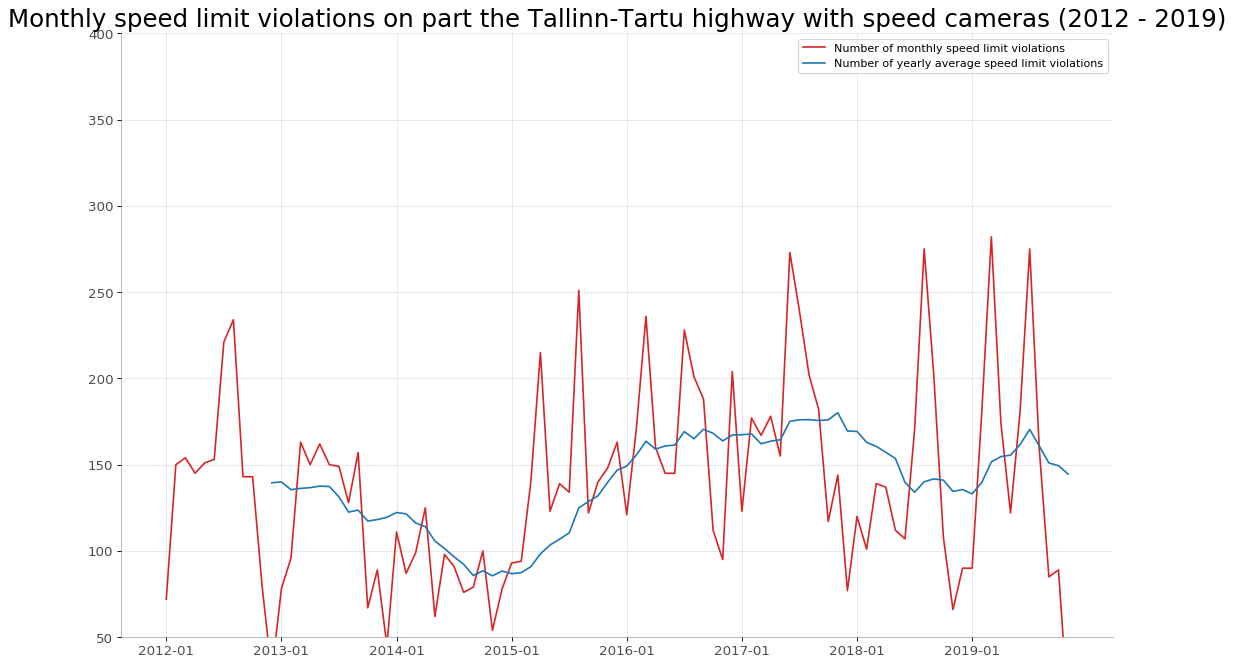

In [10]:
#Copy the main dataframe
data_kaamerad = data4[data4["MntVoiTanav"] == "MNT"].copy()
#Change the date column to a date type
data_kaamerad["ToimKpv"] = pd.to_datetime(data_kaamerad["ToimKpv"])

#Choose all of the rows that are on the Talllin-Tartu highway, the misdemeanor is speeding, and the KM is between 47 and 151.
data_kaamerad = data_kaamerad[(data_kaamerad['MntTanavNimetus'].str.contains("TALLINN")) & (data_kaamerad['MntTanavNimetus'].str.contains("TARTU")) & (data_kaamerad['Paragrahv'] == "§ 227.") & (data_kaamerad["KM"] < 151) & (data_kaamerad["KM"] > 47)]

#Choose only the necessary rows
data_kaamerad_TLN_TRT_graph = data_kaamerad[["ToimKpv", "Paragrahv"]]
#Set the date as index

data_kaamerad_TLN_TRT_graph = data_kaamerad_TLN_TRT_graph.set_index("ToimKpv")
#Group the data by months
data_kaamerad_TLN_TRT_graph = data_kaamerad_TLN_TRT_graph.resample('M').count()
#reset the index to int id-s
data_kaamerad_TLN_TRT_graph = data_kaamerad_TLN_TRT_graph.reset_index()
#Change the date back to string
data_kaamerad_TLN_TRT_graph["ToimKpv"] = data_kaamerad_TLN_TRT_graph["ToimKpv"].astype(str)


#Make a datafram with mean values, with the mean being taken from a 12-month window
data_kaamerad_TLN_TRT_graph_mean = data_kaamerad_TLN_TRT_graph.copy()
data_kaamerad_TLN_TRT_graph_mean["Paragrahv"] = data_kaamerad_TLN_TRT_graph_mean["Paragrahv"].rolling(12).mean()




# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
plt.plot('ToimKpv', 'Paragrahv', data=data_kaamerad_TLN_TRT_graph, color='tab:red',  label="Number of monthly speed limit violations")
plt.plot('ToimKpv', 'Paragrahv', data=data_kaamerad_TLN_TRT_graph_mean, color='tab:blue', label="Number of yearly average speed limit violations")
# plt.plot(data=, color='tab:blue')

# # Decoration
plt.ylim(50, 400)
xtick_location = data_kaamerad_TLN_TRT_graph.index.tolist()[::12]
xtick_labels = [x[:-3] for x in data_kaamerad_TLN_TRT_graph.ToimKpv.tolist()[::12]]
plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title("Monthly speed limit violations on part the Tallinn-Tartu highway with speed cameras (2012 - 2019)", fontsize=22)
plt.grid(axis='both', alpha=.3)
plt.legend(loc='best')

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()


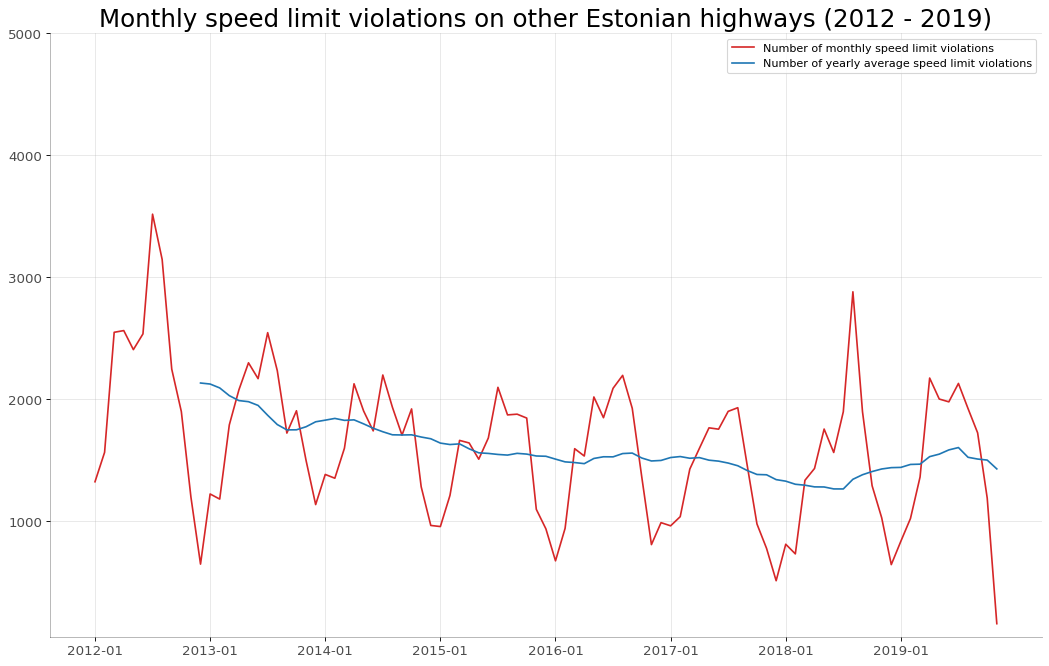

In [11]:
#Choose all of the rows that are on not the Talllin-Tartu highway, and the misdemeanor is speeding.
data_kaamerad_eesti_graph = data4[(data4['MntTanavNimetus'] != "TALLINN - TARTU - VÕRU - LUHAMAA (2)") & (data4["MntVoiTanav"] == "MNT") & (data4['Paragrahv'] == "§ 227.")].copy()
#Change the date column to a date type
data_kaamerad_eesti_graph["ToimKpv"] = pd.to_datetime(data_kaamerad_eesti_graph["ToimKpv"])
#Choose only the necessary rows
data_kaamerad_eesti_graph = data_kaamerad_eesti_graph[["ToimKpv", "Paragrahv"]]
#Set the date as index
data_kaamerad_eesti_graph = data_kaamerad_eesti_graph.set_index("ToimKpv")
#Group the data by months
data_kaamerad_eesti_graph = data_kaamerad_eesti_graph.resample('M').count()
#reset the index to int id-s
data_kaamerad_eesti_graph = data_kaamerad_eesti_graph.reset_index()
#Change the date back to string
data_kaamerad_eesti_graph["ToimKpv"] = data_kaamerad_eesti_graph["ToimKpv"].astype(str)

#Make a datafram with mean values, with the mean being taken from a 12-month window
data_kaamerad_eesti_graph_mean = data_kaamerad_eesti_graph.copy()
data_kaamerad_eesti_graph_mean["Paragrahv"] = data_kaamerad_eesti_graph_mean["Paragrahv"].rolling(12).mean()

# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
plt.plot('ToimKpv', 'Paragrahv', data=data_kaamerad_eesti_graph, color='tab:red',  label="Number of monthly speed limit violations")
plt.plot('ToimKpv', 'Paragrahv', data=data_kaamerad_eesti_graph_mean, color='tab:blue', label="Number of yearly average speed limit violations")
# plt.plot(data=, color='tab:blue')

# # Decoration
plt.ylim(50, 5000)
xtick_location = data_kaamerad_eesti_graph.index.tolist()[::12]
xtick_labels = [x[:-3] for x in data_kaamerad_eesti_graph.ToimKpv.tolist()[::12]]
plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title("Monthly speed limit violations on other Estonian highways (2012 - 2019)", fontsize=22)
plt.grid(axis='both', alpha=.3)
plt.legend(loc='best')

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()


In [12]:
datax = data4.copy()
datax = datax.groupby("ParagrahvTais").count()
datax.sort_values(by="Paragrahv", ascending=False)

,ToimKpv,ToimKell,ToimNadalapaev,Seadus,Paragrahv,MaakondNimetus,ValdLinnNimetus,KohtNimetus,MntVoiTanav,MntTanavNimetus,KM,Lest_X,Lest_Y,SoidukLiik,SoidukRegRiik,SoidukMark,SoidukVlAasta,RikkujaSugu,RikkujaVanus,SyyteoLiik
ParagrahvTais,,,,,,,,,,,,,,,,,,,,
§ 227. Mootorsõidukijuhi poolt lubatud sõidukiiruse ületamine,338265,338265,338265,338265,338265,338265,338265,338265,338265,338265,184043,338265,338265,338265,338265,338265,338265,338265,338265,338265
§ 242. Mootorsõiduki- või trammijuhi poolt liiklusnõuete muu rikkumine,77187,77187,77187,77187,77187,77187,77187,77187,77187,77187,14946,77187,77187,77187,77187,77187,77187,77187,77187,77187
"§ 259. Jalakäija, tasakaaluliikuri juhi, jalgratturi, pisimopeedijuhi, loomveoki juhi või sõitja poolt liiklusnõuete muu rikkumine",65513,65513,65513,65513,65513,65513,65513,65513,65513,65513,6872,65513,65513,65513,65513,65513,65513,65513,65513,65513
§ 239. Turvavarustuse nõuetekohaselt kinnitamata jätmine,52180,52180,52180,52180,52180,52180,52180,52180,52180,52180,4163,52180,52180,52180,52180,52180,52180,52180,52180,52180
"§ 201. Mootorsõiduki, maastikusõiduki või trammi juhtimine juhtimisõiguseta isiku poolt",44243,44243,44243,44243,44243,44243,44243,44243,44243,44243,11573,44243,44243,44243,44243,44243,44243,44243,44243,44243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"§ 219. Mootorsõiduki või maastikusõiduki juhtimise eest, mille heitmete saasteainesisaldus või tekitatav müra ületab kehtestatud normatiivi, – karistatakse rahatrahviga kuni 50 trahviühikut.",2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2
"§ 210'4. Kuni 12 000 kilogrammi lubatud täismassiga sõiduki, autorongi ja masinrongi, mille maksimaalset lubatud täismassi on ületatud, juhtima lubamine",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
§ 220. Keskkonnaohtlikku mootorsõidukit või maastikusõidukit juhtima lubamine,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
